# Using HTMD to setup a DNA simulation in explicit solvent

HTMD: High-Throughput Molecular Dynamics for Molecular Discovery
S. Doerr, M. J. Harvey, Frank Noé, and G. De Fabritiis
Journal of Chemical Theory and Computation 2016 12 (4), 1845-1852
DOI: 10.1021/acs.jctc.6b00049.

    
https://software.acellera.com/docs/latest/htmd/index.html

Before you start, make sure that HTMD is installed on your machine. 
HTMD can be installed using conda.
Best to create a conda HTMD environment

conda create -n htmd python=3.7

conda activate htmd

conda install -c acellera -c conda-forge htmd


This workshop will work best in a jupyter-notebook (set up part and analysis) and a terminal (running the simulations). The first thing to do is to open a new terminal: from the jupyter home page click the new button on the top right and select terminal. You might want to open the terminal in a new window (right click on terminal and select open in new window). Don't close this notebook (until you have finished the tutorial)!

Lines in this notebook that begin with > are the lines that you type into the terminal command line. Sample input files can be found in data/.

In [4]:
from htmd.ui import *
config(viewer='ngl') #You can use webgl or vmd as well

## Import your PDB structure

In [2]:
dna = Molecule('109D')

2021-07-02 00:38:14,744 - moleculekit.readers - INFO - Attempting PDB query for 109D


In [5]:
dna.view()

_ColormakerRegistry()

NGLWidget()

<b>NOTE:</b> You will notice that besides the duplex DNA, there is a ligand, a magnesium ion and some water molecules in the file. To set up DNA, we need to remove the ligand and the magnesium ion first. We shall add the ligand to the system later. 

In [6]:
dna.remove('resname IBB')
dna.remove('resname MG')

2021-07-02 00:39:14,302 - moleculekit.molecule - INFO - Removed 30 atoms. 577 atoms remaining in the molecule.
2021-07-02 00:39:14,312 - moleculekit.molecule - INFO - Removed 1 atoms. 576 atoms remaining in the molecule.


array([486], dtype=int32)

<b>NOTE:</b> HTMD requires that every component of the complex is segregated as separate segments

In [7]:
dna = autoSegment(dna, sel='nucleic')
dna.set('segid', 'P', sel='nucleic')
dna.set('segid', 'W', sel='water')

<b>NOTE:</b> Previously we have already parameterized the ligand. All the preprepared files can be found in ./data

In [8]:
ligand = Molecule('./data/mol.mol2')

<b>NOTE:</b> We need to provide the segid for the ligand too

In [9]:
ligand.set('segid','L')
ligand.set('resname','MOL')

## Combining ligand to the DNA file

<b>NOTE:</b> You can visualise the DNA, ligand and the crystallographic waters

In [23]:
mol = Molecule(name='combo')
mol.append(dna)
mol.append(ligand)
mol.reps.add(sel='nucleic', style='Lines', color=None)
mol.reps.add(sel='resname MOL', style='Licorice')
mol.view()

NGLWidget()

## Setting up the box size and solvation

In [20]:
smol = solvate(mol, pad=12) # box size 12 Ang from edge of solute
smol.reps.add(sel='water', style='Lines')
smol.reps.add(sel='resname MOL or nucleic', style='Licorice')
smol.view(viewer='ngl')

2021-07-02 00:43:48,657 - htmd.builder.solvate - INFO - Using water pdb file at: /home/shozeb/miniconda3/envs/htmd/lib/python3.7/site-packages/htmd/share/solvate/wat.pdb
2021-07-02 00:43:49,250 - htmd.builder.solvate - INFO - Replicating 2 water segments, 1 by 1 by 2
Solvating: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
2021-07-02 00:43:50,232 - htmd.builder.solvate - INFO - 5134 water molecules were added to the system.


NGLWidget()

## Check and add appropriate force field

In [24]:
amber.listFiles()

---- Forcefield files list: /usr/local/amber20/dat/leap/cmd/ ----
leaprc.amberdyes
leaprc.conste
leaprc.constph
leaprc.DNA.bsc1
leaprc.DNA.OL15
leaprc.ffAM1
leaprc.ffPM3
leaprc.gaff
leaprc.gaff2
leaprc.GLYCAM_06EPb
leaprc.GLYCAM_06j-1
leaprc.lipid14
leaprc.lipid17
leaprc.mimetic.ff15ipq
leaprc.modrna08
leaprc.music
leaprc.phosaa10
leaprc.phosaa14SB
leaprc.phosaa19SB
leaprc.protein.fb15
leaprc.protein.ff03.r1
leaprc.protein.ff03ua
leaprc.protein.ff14SB
leaprc.protein.ff14SB_modAA
leaprc.protein.ff14SBonlysc
leaprc.protein.ff15ipq
leaprc.protein.ff15ipq-vac
leaprc.protein.ff19ipq
leaprc.protein.ff19SB
leaprc.protein.ff19SB_modAA
leaprc.RNA.LJbb
leaprc.RNA.OL3
leaprc.RNA.ROC
leaprc.RNA.Shaw
leaprc.RNA.YIL
leaprc.water.fb3
leaprc.water.fb4
leaprc.water.opc
leaprc.water.spce
leaprc.water.spceb
leaprc.water.tip3p
leaprc.water.tip4pd
leaprc.water.tip4pew
leaprc.xFPchromophores
---- OLD Forcefield files list: /usr/local/amber20/dat/leap/cmd/ ----
oldff/leaprc.DNA.bsc0
oldff/leaprc.ff02
oldff/l

<b>NOTE:</b> Add full path to force fields if they are installed in a non-conventional place

In [25]:
ffs = ['/home/shozeb/miniconda3/envs/htmd/dat/leap/cmd/leaprc.DNA.bsc1', '/home/shozeb/miniconda3/envs/htmd/dat/leap/cmd/leaprc.DNA.OL15', '/home/shozeb/miniconda3/envs/htmd/dat/leap/cmd/leaprc.water.tip3p']

<b>NOTE:</b> Add the parameters for the ligand. They have been precalculated and saved in ./data

In [26]:
frcmods_amber = ffs + ['./data/mol.frcmod']

## Build the system

(In 0.1M KCl)

In [27]:
molbuilt = amber.build(smol, param=frcmods_amber, ionize=True, saltcation='K', saltconc=0.1, outdir='./build')

2021-07-02 00:45:53,077 - htmd.builder.amber - INFO - Detecting disulfide bonds.
2021-07-02 00:45:53,472 - htmd.builder.amber - INFO - Starting the build.
2021-07-02 00:46:35,298 - htmd.builder.amber - INFO - Finished building.
2021-07-02 00:46:36,158 - htmd.builder.ionize - INFO - Adding 0 anions + 22 cations for neutralizing and 20 ions for the given salt concentration.
2021-07-02 00:46:39,284 - htmd.builder.amber - INFO - Starting the build.
2021-07-02 00:47:20,681 - htmd.builder.amber - INFO - Finished building.


In [28]:
molbuilt.view(sel='not water')

NGLWidget()

### Switching to terminal 

Do not close this notebook.


Goto file open -> New (on top right hand corner) -> terminal

Once the system is built, you will have a directory called 'build' that will have structure.crd, structure.prmtop and structure.pdb. You can use these to run your simulations. 

Goto the build directory

\> cd build

## Input files

For explicit solvents igb = 0 which is the default value (if you don't specify a value for igb in your input Amber will set it to 0).

All input files to run minimisation, equilibration and production run are present in ./input_files
You can copy the files from ./input_files to ./build

## Using Pmemd/Pmemd.cuda

The molecular dynamics is run by the pmemd module. The pmemd executable is found in $AMBERHOME/bin. You can read the manual to find the details of all the options for pmemd. Some of the important ones are:

    -O or -A : Overwrite or Append output files if they already exist
    
    -i FILE_NAME.in (input) : control data for the run
    
    -o FILE_NAME.out (output) : user readable information
    
    -p FILE_NAME.prmtop (input) : molecular topology, force field, atom and residue names, periodic box type
    
    -c FILE_NAME.crd (input) : initial coordinates and periodic box size (may include velocities)
    
    -r FILE_NAME.rst (output) : final coordinates, velocities, and box dimentions (for restarting run) 
    
    -x FILE_NAME.nc (output) : trajectory file 
    
* Example (you will have to use your own filenames) 

\> pmemd -O -i 01_Min.in -o 01_Min.out -inf 01_Min.inf -p structure.prmtop -c structure.crd -ref structure.crd -r 01_Min.rst -x 01_Min.nc -e 01_Min.ene

## EQUILIBRATION :

### (A) MINIMISATION

To equilibrate the system, we first relax by running an energy minimisation (01_Min.in). This helps to remove any bad contacts (slightly misplaced atoms) in the initial structure.

\> pmemd -O -i 01_Min.in -o 01_Min.out -inf 01_Min.inf -p structure.prmtop -c structure.crd -ref structure.crd -r 01_Min.rst -x 01_Min.nc 


### (B) HEATING

We then heat the system up in the presence of restraints on the solute (02_Heat.in). Heating the system is followed by MD at the desired temperature (03_Heat2.in) and then reducing the restraints (04_Heat3.in). This stepwise equilibration procedure allows the system to gradually relax without changing too much at any one time (which could cause simulations to become unstable and crash the MD program).

This equilibration needs to be particularly gentle for DNA simulations to ensure that the solvent and counterions screen the negatively charged backbone.

\> $AMBERHOME/bin/pmemd -O -i 02_Heat1.in   -o 02_Heat1.out   -p structure.prmtop   -c 01_Min.rst   -r 02_Heat1.rst   -ref 01_Min.rst   -x 02_Heat1.nc  

* Why dont we use the second step with pmemd.cuda? This is to ensure that the box dimensions dont change too quickly. They system becomes unstable if that happens. 

\> $AMBERHOME/bin/pmemd -O -i 03_Heat2.in -o 03_Heat2.out -p structure.prmtop -c 02_Heat1.rst -ref 02_Heat1.rst -r 03_Heat2.rst -x 03_Heat2.nc 

* Hold the system at 303 K and reduce the restraints

\> $AMBERHOME/bin/pmemd.cuda -O -i 04_Heat3.in -o 04_Heat3.out -p structure.prmtop -c 03_Heat2.rst -ref 03_Heat2.rst -r 04_Heat3.rst -x 04_Heat3.nc 

## PRODUCTION RUN

\> $AMBERHOME/bin/pmemd.cuda -O -i 01_Prod-0.in -o 01_Prod-0.out -p structure.prmtop -c 04_Heat3.rst -ref 04_Heat3.rst -r 01_Prod-0.rst -x 01_Prod-0.nc 


## Visualising the results

There are several programs available for visualising MD trajectories (VMD and Chimera are popular). In Jupyter notebooks, we can use NGLview (with MDtraj to import the trajectory).

You can find the NGLview documentation at http://nglviewer.org/nglview/latest/index.html.

In [29]:
import mdtraj as mdt
import nglview as nv

<b>NOTE:</b> Just in case you are unable to run the simulation, we have already run this for you. In the ./data directory, you will find the structure.prmtop and dna_simulation.nc files. You can use these files to visualise the simulation.

In [30]:
# select your files
top_file = './data/dna_nowater.prmtop' # your prmtop here
traj_file = './data/dna_nowater.nc' # your trajfile here

In [31]:
# load trajectory with MDtraj
traj = mdt.load(traj_file, top=top_file)

In [45]:
#view with NGLview
view = nv.show_mdtraj(traj)

# Clear all representations to try new ones
view.clear_representations()

# Show licorice style representation
view.add_representation('licorice', selection='not water')
view

NGLWidget(max_frame=1011)

## Repeat or replicate simulations

One way to perform an independent “repeat” of a simulation is to reassign the velocities at a chosen point in the trajectory. 

The ntx and irest flags in the .in file change (ntx=1, irest=0).

Make a new directory.

Running on from your restart file from 04_Heat (eg 04_Heat3.rst), run an independent repeat of your previous simulation by makeing a new input file to reassign a new set of velocities. Call this trajectory something different.

Compare the two trajectories, and convince yourself that they are different.

# RMSD Analysis

In [27]:
import os.path as op
problems = False
top_file = './data/dna_nowater.prmtop'
traj_file = './data/dna_nowater.nc'
try:
    import mdtraj as mdt
except ImportError:
    print('Error: you don\'t seem to have mdtraj installed - use pip or similar to get it then try again.')
    problems = True
try:
    import numpy as np
except ImportError:
    print('Error: you don\'t seem to have numpy installed - use pip or similar to get it then try again.')
    problems = True
try:
    import matplotlib.pyplot as plt
    # This next line makes matplotlib show its graphs within the notebook.
    %matplotlib inline 
except ImportError:
    print('Error: you don\'t seem to have matplotlib installed - use pip or similar to get it then try again.')
    problems = True
try:
    import nglview as nv
except ImportError:
    print('Error: you don\'t seem to have nglview installed - use pip or similar to get it then try again.')
    problems = True

if not op.exists(top_file):
    print('Error: you don\'t seem to have the data file {} in this directory.'.format(top_file))
    problems = True
if not op.exists(traj_file):
    print('Error: you don\'t seem to have the data file {} in this directory.'.format(traj_file))
    problems = True

if problems:
    print('Fix the errors above then re-run this cell')
else:
    print('Success! You seem to have everything ready to run the notebook.')
plt.rcParams.update({'font.size': 15}) #This sets a better default label size for plots

Success! You seem to have everything ready to run the notebook.


In [28]:
traj = mdt.load(traj_file, top=top_file)
import nglview as nv
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=1011)

In [29]:
print(traj)
print(type(traj.xyz))
print(traj.xyz.shape)

<mdtraj.Trajectory with 1012 frames, 16394 atoms, 5249 residues, and unitcells>
<class 'numpy.ndarray'>
(1012, 16394, 3)


So you can see that the trajectory coordinate data is stored in the numpy array *traj.xyz*. This is a three-dimensional array of shape [n_frames, n_atoms, 3]. 

**NB:** MDTraj stores coordinates in nanometer units.

---

## NOTE: 
(1) MDtraj does not have built-in functionalities to analyze DNA backbones like Protein. So we have to manually select backbone atoms of nucleic acids (P O5' C5' C4' C3' O3'). We also need to be careful about how the single quote have to be selected within a double quotes to make this work in MDtraj.

(2) Once selected, we have to make a new trajectory of selected atoms and then use the rmsd function to get our desired plot

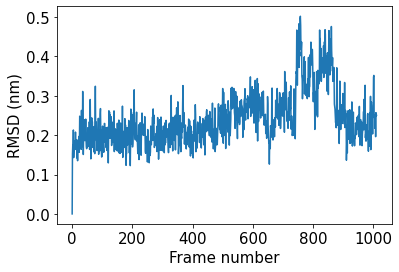

In [30]:
selection = traj.topology.select('name P "O5\'" "C5\'" "C4\'" "C3\'" "O3\'"')
seldata = mdt.Trajectory(traj.xyz[:, selection], traj.topology.subset(selection))

rmsd = mdt.rmsd(seldata, seldata[0])
plt.xlabel('Frame number')
plt.ylabel('RMSD (nm)')

plt.plot(rmsd)

Visualise the trajectory and see what is happening with the DNA backbone between frames 700-900? Does the change recover to its original conformation? 